# Índice
1. [Set up inicial](#Set-up-inicial)
    
    1.1 [Carga de datos](#Carga-de-datos)
    
    1.2 [Informacion del dataset de edificios](#Informacion-del-dataset-de-edificios)
    
    1.3 [Informacion del dataset de daños](#Informacion-del-dataset-de-daños)
2. [Entendiendo el data set](#Entendiendo-el-data-set)
    
    2.1 [Antiguedad de los edificios](#Antiguedad-de-los-edificios)
    
    2.2 [Ubicacion geografica](#Ubicacion-geografica)
    

## Set up inicial

In [1]:
# importacion general de librerias y de visualizacion (matplotlib y seaborn)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random as rd
%matplotlib inline

plt.style.use('default') # haciendo los graficos un poco mas bonitos en matplotlib
#plt.rcParams['figure.figsize'] = (20, 10)

sns.set(style="whitegrid") # seteando tipo de grid en seaborn

pd.options.display.float_format = '{:20,.2f}'.format # suprimimos la notacion cientifica en los outputs

import warnings
warnings.filterwarnings('ignore')

## Carga de datos

Se cargan las columnas con formatos adecuados según el tipo de datos

In [2]:
#Levantar los datos de cada edificio/casa
df = pd.read_csv('datos/train_values.csv',nrows=0)
columnas = df.columns.to_list()
datatypes = {
    **{columnas[0]:np.int32}\
    , **{column:np.int16 for column in columnas[1:8] + columnas[27:28]}\
    , **{column:'category' for column in columnas[8:15] + columnas[26:27]}\
    , **{column:np.bool for column in columnas[15:26] + columnas[28:39]}
}
edificios = pd.read_csv('datos/train_values.csv',dtype=datatypes)

In [3]:
#Datos de el daño por edificio
daños = pd.read_csv('datos/train_labels.csv',dtype={'building_id':np.int32,'damage_grade':'category'})

## Informacion del dataset de edificios

In [4]:
edificios.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260601 entries, 0 to 260600
Data columns (total 39 columns):
 #   Column                                  Non-Null Count   Dtype   
---  ------                                  --------------   -----   
 0   building_id                             260601 non-null  int32   
 1   geo_level_1_id                          260601 non-null  int16   
 2   geo_level_2_id                          260601 non-null  int16   
 3   geo_level_3_id                          260601 non-null  int16   
 4   count_floors_pre_eq                     260601 non-null  int16   
 5   age                                     260601 non-null  int16   
 6   area_percentage                         260601 non-null  int16   
 7   height_percentage                       260601 non-null  int16   
 8   land_surface_condition                  260601 non-null  category
 9   foundation_type                         260601 non-null  category
 10  roof_type                       

Se puede ver que los datos utilizan los datatypes correspondientes según la información dada en la consigna. Esto es, teniendo en cuenta los rangos de cada columna, y verificando que no hay datos inválidos.

Se puede apreciar que hay columnas relacionadas como la de uso secundario o superestructura.

In [5]:
edificios.head(3)

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,...,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other
0,802906,6,487,12198,2,30,6,5,t,r,...,False,False,False,False,False,False,False,False,False,False
1,28830,8,900,2812,2,10,8,7,o,r,...,False,False,False,False,False,False,False,False,False,False
2,94947,21,363,8973,2,10,5,5,t,r,...,False,False,False,False,False,False,False,False,False,False


## Informacion del dataset de daños

In [6]:
daños.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 260601 entries, 0 to 260600
Data columns (total 2 columns):
 #   Column        Non-Null Count   Dtype   
---  ------        --------------   -----   
 0   building_id   260601 non-null  int32   
 1   damage_grade  260601 non-null  category
dtypes: category(1), int32(1)
memory usage: 1.2 MB


De la misma manera, según el enunciado, podemos asignar al damage_grade como tipo categórico. 

In [7]:
daños.head(3)

,building_id,damage_grade
0,802906,3
1,28830,2
2,94947,3


## Entendiendo el dataset

Según los datos disponibles, nos inducen a relacionar los edificios con el terremoto.

Antes de relacionarlos directamente veamos si por separado nos pueden dar algún insight de la situación

## Antiguedad de los edificios

<AxesSubplot:>

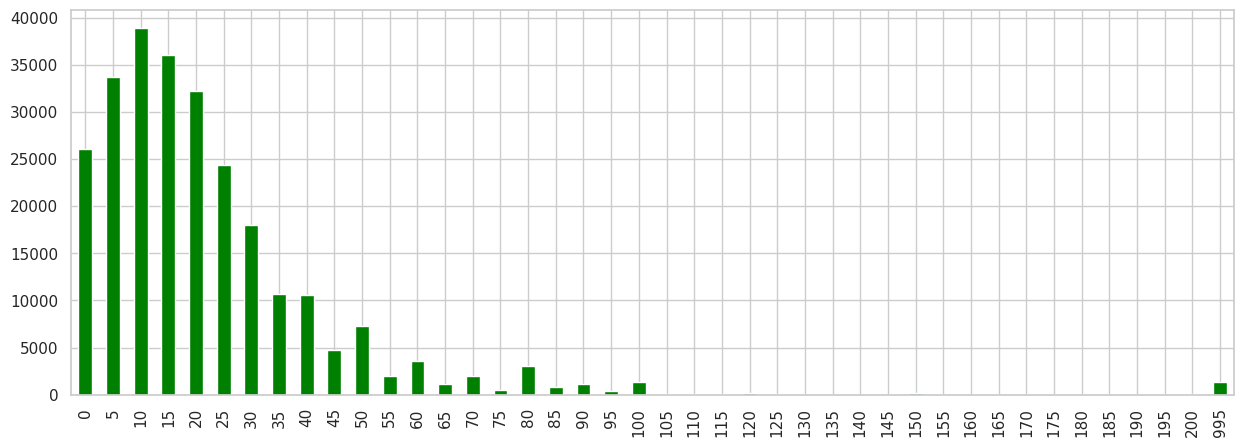

In [8]:
edificios['age'].value_counts().sort_index().plot(kind='bar',color='green',figsize=(15,5))

In [9]:
edificios_edad = edificios['age']
edificios_edad.describe()

count             260,601.00
mean                   26.54
std                    73.57
min                     0.00
25%                    10.00
50%                    15.00
75%                    30.00
max                   995.00
Name: age, dtype: float64

Hay valores muy alejados de la media, y al parecer ninguna entre 100 y 995.

Me pregunto si estos casos serán significativos y si los puedo agrupar en una categoria

In [10]:
edif_mas_105 = edificios_edad.loc[edificios_edad>100].value_counts().sort_index().sum()
edif_mas_105/edificios_edad.sum() * 100

0.030715590837672294

Un 0.03% es bastante poco representantivo ?

Veamos que pasa si agrupo estos valores

<AxesSubplot:>

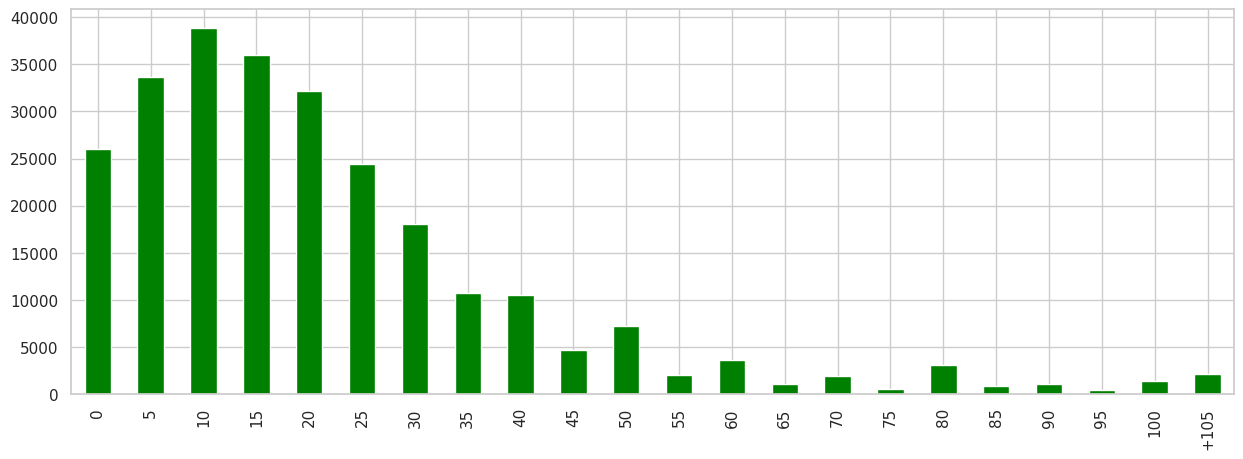

In [11]:
freq_edades = edificios.loc[edificios['age']<105,'age'].value_counts().sort_index()
freq_edades = freq_edades.append(pd.Series({'+105':edif_mas_105}))
freq_edades.plot(kind='bar',color='green',figsize=(15,5))

No parece muy representativo los edificios de +105, tampoco es una razón para descartar estos datos ya que pueden ser de importancia cuando se trata de catástrofes.
Pero si está bien analizarla por separado

## Ubicacion geografica

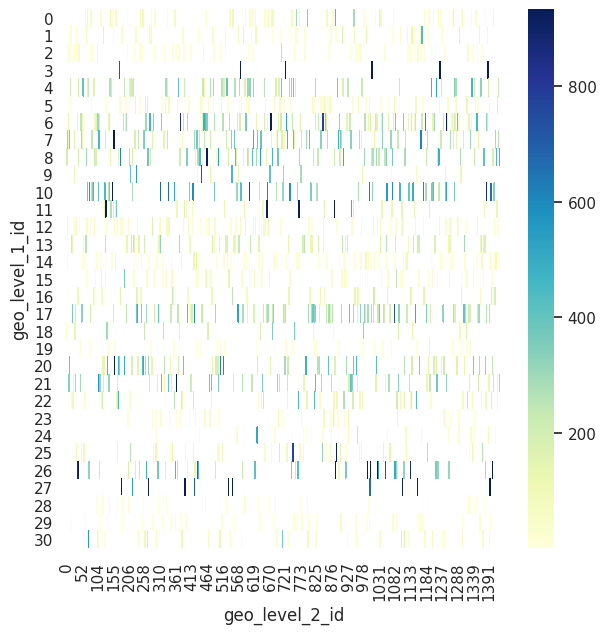

In [115]:
flights = sns.load_dataset("flights")
flights = flights.pivot("month", "year", "passengers")

#ax = sns.heatmap(flights, cbar=False)
geo_edif = edificios[['geo_level_1_id','geo_level_2_id','building_id']]\
    .groupby(['geo_level_1_id','geo_level_2_id']).count().reset_index()
pivoted = geo_edif.pivot("geo_level_1_id","geo_level_2_id","building_id")
f, ax = plt.subplots(figsize=(7, 7))
ax = sns.heatmap(pivoted,robust=True,cmap='YlGnBu')

Este grafico intenta mostrar por cada región mas grande, la cantidad de edificios en la subregión.
* Vemos que en las regiones grandes, hay sectores que se dividen uniformemente como la region 4.
* También hay poco distribuidos como la 3
* Las regiones con más edificios son las 6,7,8 y 10. También están bien distribuidas